### First things First - Make notebook to connect with current directory

In [0]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr  5 23:10:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
### For working on google colab

from google.colab import drive

drive.mount('/content/gdrive')
cur_dir = 'gdrive/My Drive/SRGAN Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
sys.path.append(cur_dir)

In [0]:
import os 
os.chdir(cur_dir)
os.getcwd()

'/content/gdrive/My Drive/SRGAN Project'

### Import Libraries

In [0]:
!pip install tensorflow-gan

     |████████████████████████████████| 368kB 3.4MB/s 


In [0]:
%tensorflow_version 2.x

import tensorflow.compat.v1 as tf
print(tf.__version__)

import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


2.2.0-rc2



In [0]:
import glob
import cv2
from google.colab.patches import cv2_imshow
import numpy as np


In [0]:
from predictions_utils import *

In [0]:
%load_ext autoreload
%autoreload 2

### Super-resolution of Images

In [0]:
# { 'data/Vid4/GT/city/*.png' , 'data/sets/Set5/*.png' }

In [0]:
tf.logging.set_verbosity(False)

input_images_file_path = 'data/Vid4/GT/foliage/*.png' #

perpix_model_path = 'gpuestimator-tfgan/saved-perpixloss/export_saved_model/gan_estimator_export/version_3'
mse_model_path = 'gpuestimator-tfgan/saved-mseloss/export_saved_model/gan_estimator_export/version_1'

In [41]:
psnr_scores_list_perpix = []
psnr_scores_list_mse = []
super_resolved_images_list = []
input_images_list = []
images_counter = 0
save_images = False

for file_i in glob.glob(input_images_file_path):

    ### INPUT IMAGES TO NUMPY ARRAY 
    input_img = cv2.imread(file_i, cv2.IMREAD_UNCHANGED)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    input_img_norm = input_img/255.0  ### To make range of pixel values [0, 1]

    orig_img_shape = input_img_norm.shape

    if orig_img_shape[1]%4 != 0 and orig_img_shape[0]%4 != 0:
        tmp_1 = orig_img_shape[0]%4 
        tmp_2 = orig_img_shape[1]%4 
        input_img_rescaled = input_img_norm[:-tmp_1, :-tmp_2, :]
    elif orig_img_shape[1]%4 != 0:
        tmp_2 = orig_img_shape[1]%4 
        input_img_rescaled = input_img_norm[:, :-tmp_2, :]
    elif orig_img_shape[0]%4 != 0:
        tmp_1 = orig_img_shape[0]%4 
        input_img_rescaled = input_img_norm[:-tmp_1, :, :]
    else:
        input_img_rescaled = input_img_norm

    input_images_list.append(input_img_rescaled.tolist())

    img_width = int(input_img_rescaled.shape[1]/4.0 ) ## Be careful here
    img_height = int(input_img_rescaled.shape[0]/4.0 )  ## Be careful here

    input_img_resized = cv2.resize(input_img_rescaled , dsize = (img_width, img_height), interpolation = cv2.INTER_CUBIC ) ## Downsample the images

    input_img_expanded = np.expand_dims(input_img_resized, axis= 0) ### (1, None, None, 3) format

    plt.figure(figsize= (20, 20))

    plt.subplot(1, 4, 1)
    # 
    plt.imshow(input_img_resized)
    plt.axis("off")
    plt.title("Downsampled image")

    
    # cv2_imshow(input_img)
    plt.subplot(1, 4, 2)
    plt.imshow(input_img_norm)
    plt.axis("off")
    plt.title("Original image")

    
    ### Do inference using the "predict_function" 

    perpix_pred = predict_function(input_img_expanded ,model_path = perpix_model_path )

    mse_pred = predict_function(input_img_expanded ,model_path = mse_model_path )

    ### Rescale and compute PSNR between original image and super-resolution image 

    single_prediction = np.squeeze(perpix_pred, axis= 0)
    single_prediction_rescaled = (single_prediction + 1.0 ) /2.0

    super_resolved_images_list.append(single_prediction_rescaled.tolist())
    
    single_prediction_mse = np.squeeze(mse_pred, axis= 0)
    single_prediction_rescaled_mse = (single_prediction_mse + 1.0 ) /2.0


    # cv2_imshow(single_prediction_rescaled * 255.0)

    plt.subplot(1, 4, 3)
    plt.imshow(single_prediction_rescaled_mse)
    plt.axis("off")
    plt.title("Super-Resolution image - MSE")

    plt.subplot(1, 4, 4)
    plt.imshow(single_prediction_rescaled)
    plt.axis("off")
    plt.title("Super-Resolution image - Perpix")
    plt.tight_layout()
    if save_images:
      plt.savefig("result_images" + str(images_counter) )
    plt.show()

    images_counter = images_counter + 1
    
    ## With perpix model
    computed_psnr = tf.compat.v1.image.psnr(input_img_rescaled, single_prediction_rescaled, max_val=1.0, name="PSNR TEST - PERPIX")
      
    tmp_psnr = tfds.as_numpy(computed_psnr).tolist()
    psnr_scores_list_perpix.append(tmp_psnr)

    ## With MSE model
    computed_psnr_mse = tf.compat.v1.image.psnr(input_img_rescaled, single_prediction_rescaled_mse, max_val=1.0, name="PSNR TEST - MSE")
      
    tmp_psnr_mse = tfds.as_numpy(computed_psnr_mse).tolist()
    psnr_scores_list_mse.append(tmp_psnr_mse)

cv2.destroyAllWindows()

try:  
  super_resolved_images = np.array(super_resolved_images_list, dtype = 'float32')
  input_images = np.array( input_images_list, dtype = 'float32' )
  print(super_resolved_images.shape)
  print(input_images.shape)
except:
  pass


Output hidden; open in https://colab.research.google.com to view.

In [0]:
plot_grid_images(input_array_grid = input_images, grid_shape = (1, 5) ,  title = "Test Images Batch" , save_file_path = "./report_images/test_images_batch.png" , fig_size = (20, 10))


In [0]:
print(psnr_scores_list_perpix)
print("Perpix model mean of psnr scores is : {} " .format(np.array(psnr_scores_list_perpix).mean()))

print(psnr_scores_list_mse)
print("MSE model mean of psnr scores is : {} " .format(np.array(psnr_scores_list_mse).mean()))

[26.666967391967773, 26.45863151550293, 22.225967407226562, 28.194448471069336, 20.142940521240234, 28.415281295776367, 19.66972541809082, 23.321645736694336, 23.18537139892578, 23.098968505859375, 24.165515899658203, 23.396427154541016, 19.618270874023438, 26.378034591674805]
Perpix model mean of psnr scores is : 23.924156870160783 
[26.331012725830078, 26.383668899536133, 22.249908447265625, 28.07977294921875, 19.892620086669922, 28.423603057861328, 19.608043670654297, 23.201753616333008, 23.116689682006836, 22.813209533691406, 24.141056060791016, 23.108619689941406, 19.548599243164062, 25.857088088989258]
MSE model mean of psnr scores is : 23.768260410853795 


In [0]:
set5_mean_psnr_mse = np.array(psnr_scores_list_mse).mean()
print(set5_mean_psnr_mse)
set5_mean_psnr_perpix = np.array(psnr_scores_list_perpix).mean()
print(set5_mean_psnr_perpix)

26.53302345275879
26.569468307495118


In [0]:
set14_mean_psnr_mse = np.array(psnr_scores_list_mse).mean()
print(set14_mean_psnr_mse)

set14_mean_psnr_perpix = np.array(psnr_scores_list_perpix).mean()
print(set14_mean_psnr_perpix)

23.768260410853795
23.924156870160783


### Super-resolution of Faces dataset from the tensorflow datasets

In [0]:
import tensorflow_datasets as tfds

In [0]:
predict_ds = tfds.load('lfw' , split='train' )

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteJR91RY/lfw-train.tfrecord



Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [0]:
predict_ds_2 = predict_ds.map(lambda features : features['image'] )
predict_ds_2

<DatasetV1Adapter shapes: (250, 250, 3), types: tf.uint8>

In [0]:
predict_ds_batch = predict_ds_2.batch(20, drop_remainder=True)

In [0]:
predict_ds_batch

<DatasetV1Adapter shapes: (20, 250, 250, 3), types: tf.uint8>

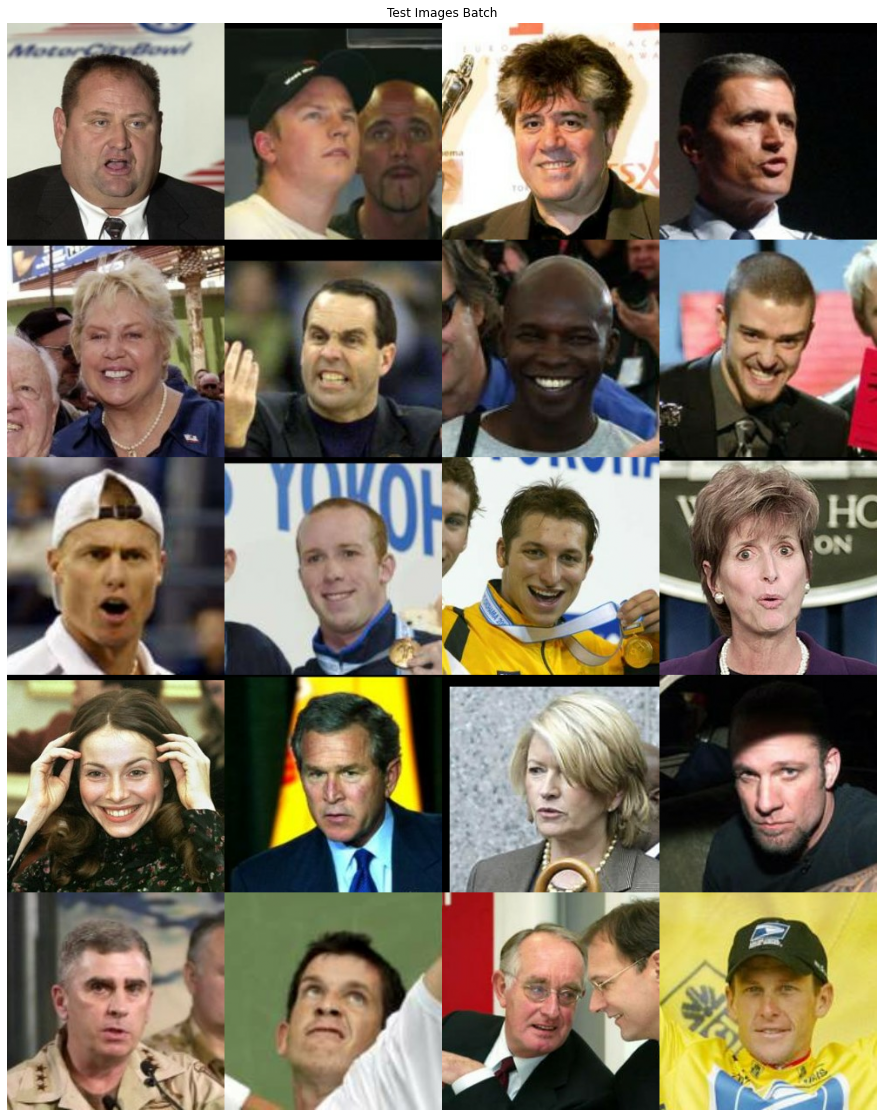

(20, 250, 250, 3)


In [0]:
valid_numpy_imgs = next(tfds.as_numpy(predict_ds_batch))

valid_numpy_imgs = valid_numpy_imgs/255.0

plot_grid_images(input_array_grid = valid_numpy_imgs, grid_shape = (5, 4) ,  title = "Test Images Batch" , save_file_path = "./report_images/test_images_batch.png" , fig_size = (20, 20))

print(valid_numpy_imgs.shape)

In [0]:
predictions = predict_function(numpy_imgs = valid_numpy_imgs , model_path = perpix_model_path )
predictions.shape

print(predictions.max())

print(predictions.min())

predictions_rescaled = ( predictions + 1.0) / 2.0


0.9989496
-0.99974513


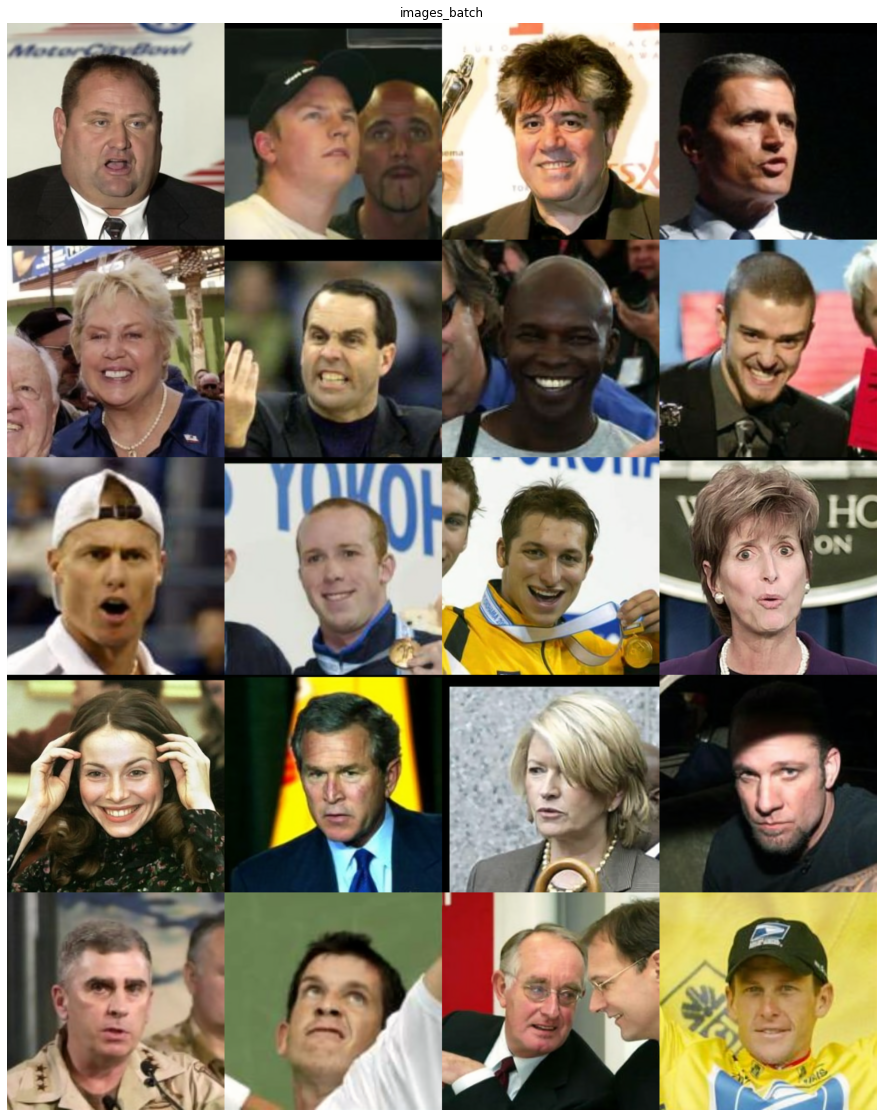

In [0]:

plot_grid_images(predictions_rescaled )

### Super-resolution of Videos

In [0]:
video_file_path  = "./faces.avi"

input_video, NUM_OF_FRAMES, FRAME_WIDTH, FRAME_HEIGHT = video_reader(input_file_path= video_file_path)

print("Input video Array shape : {} \n" .format(input_video.shape) )
print("Number of Frames in the input video file are : {} \n" .format(NUM_OF_FRAMES))
print("Frame Width is : {} \n" .format(FRAME_WIDTH))
print("Frame Height is : {} \n" .format(FRAME_HEIGHT))

Input video Array shape : (20, 1000, 1000, 3) 

Number of Frames in the input video file are : 20 

Frame Width is : 1000 

Frame Height is : 1000 



### Write the predictions to Video File

In [0]:
video_writer(inputs = input_images, output_file_path='./foliage_original.avi' , fps = 10)